<a href="https://colab.research.google.com/github/nicolascarva/Kaggle-Tanzanian-Water-Pump/blob/main/Nicolas_Carvajal_DS_module_project_221.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'

     |████████████████████████████████| 81kB 4.0MB/s 
     |████████████████████████████████| 245kB 5.7MB/s 
     |████████████████████████████████| 61kB 10.7MB/s 
     |████████████████████████████████| 604kB 28.0MB/s 
     |████████████████████████████████| 81kB 13.2MB/s 
     |████████████████████████████████| 3.1MB 34.6MB/s 
     |████████████████████████████████| 81kB 13.6MB/s 
     |████████████████████████████████| 296kB 50.9MB/s 
  Created wheel for phik: filename=phik-0.11.0-cp36-none-any.whl size=599738 sha256=3bdbb3f975fdebdde64373be787c59be45c03a0d21013fdc68bc874ba0c5607b
  Stored in directory: /root/.cache/pip/wheels/af/54/11/aba77f21075918de02f7964eabfe8c10d5542df9e6ad10b225
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27085 sha256=b9e363364cffce648fdbabeeac19ac8e940f6b7ec171fd84573fd6e934e2fae8
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
Successfully built phik htmlmin
ERROR: go

In [2]:
from category_encoders import OneHotEncoder, OrdinalEncoder
from pandas_profiling import ProfileReport
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.feature_selection import SelectKBest
import graphviz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Decision Trees

## Kaggle

**Task 1:** [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website (the URL is in Slack). Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.

## Wrangle Data

**Task 2:** Add to the code below so that `id` is set as the index for `df`.

In [62]:
import pandas as pd

# df = pd.merge(pd.read_csv(DATA_PATH + 'waterpumps/train_features.csv'),
#               pd.read_csv(DATA_PATH + 'waterpumps/train_labels.csv'))
# YOUR CODE HERE
def wrangle(filepath1, filepath2=None):
  df_=pd.read_csv(filepath1, parse_dates= ['date_recorded'])
  
  if filepath2:
    df = pd.merge(df_,
              pd.read_csv(filepath2), on='id').set_index('id')
    
  else:
    df=df_.set_index('id')
 

 ##Change 0s in Lat and Long to NaN
  df['latitude'] = df['latitude'].mask(df['latitude'].abs() < .05, np.NaN)
  df['longitude'] = df['longitude'].mask(df['longitude'].abs() < .05, np.NaN) 
  mean_pos=df[['region_code','latitude', 'longitude']].groupby('region_code').mean()
  # long_mean_rc=df[['region_code','longitude']].groupby('region_code').mean()
  ##Replace NaNs with 
  for x in df.index.to_list():
   if df.loc[x,'latitude'] != df.loc[x,'latitude']:
     naregioncode=df.loc[x, 'region_code']
     reg_mean_lat=mean_pos.loc[naregioncode,'latitude']
     reg_mean_long=mean_pos.loc[naregioncode,'longitude']

     df.loc[x,'latitude']=reg_mean_lat
     df.loc[x,'longitude']=reg_mean_long


  # Cells dropped because of HC or only 1 value
  drop_cols_hc = [col for col in df.select_dtypes('object') 
                  if (df[col].nunique()>5000) | (df[col].nunique()==1)]

  # ['recorded_by', 'wpt_name', 'scheme_name', 'extraction_type_group','quantity_group', 'source_type', 'waterpoint_type_group']
  df=df.drop(columns=drop_cols_hc)
  print('Columns dropped because of high cardinality: ', drop_cols_hc)

  ##Drop repeated columns (trying higher cardinality first, except in columns repeated in threes (removed middle cardinality)):
  drop_cols_rep_lc = ['extraction_type','extraction_type_class','management', 'payment', 'water_quality', 'quantity',
        'source','waterpoint_type']
  drop_cols_rep_hc=['extraction_type_group', 'management_group',
       'payment_type', 'quality_group',
       'quantity_group', 'source_type', 'waterpoint_type_group']
  df=df.drop(columns=drop_cols_rep_lc)
  print('Columns dropped for being repeat: ', drop_cols_rep_lc)


  #Calculate years since construction, drop date_recorded column
  df['yrs_since_const']= (df['date_recorded'].dt.year-df['construction_year'])
  df['yrs_since_const']=df['yrs_since_const'].astype(int)
  df=df.drop(columns='date_recorded')
  #Replace >100 values of years with construction for NaN
  df.loc[(df['yrs_since_const']>100) | (df['yrs_since_const']<0), 'yrs_since_const']=np.NaN


  ### Experiment area:

  

  
  
  
  return df

df=wrangle(DATA_PATH + 'waterpumps/train_features.csv',
           DATA_PATH + 'waterpumps/train_labels.csv')
X_test=wrangle(DATA_PATH + 'waterpumps/test_features.csv')
df.shape

##Calculate mean lat and long values for region code
lat_mean_rc=df[['region_code','latitude']].set_index('region_code').groupby('region_code').mean()
long_mean_rc=df[['region_code','longitude']].set_index('region_code').groupby('region_code').mean()



## for extreme cardinality, scheme name for high percentage of NaN, extraction_type_group and quantity_group, source_type for being repeated

Columns dropped because of high cardinality:  ['wpt_name', 'subvillage', 'recorded_by']
Columns dropped for being repeat:  ['extraction_type', 'extraction_type_class', 'management', 'payment', 'water_quality', 'quantity', 'source', 'waterpoint_type']
Columns dropped because of high cardinality:  ['wpt_name', 'subvillage', 'recorded_by']
Columns dropped for being repeat:  ['extraction_type', 'extraction_type_class', 'management', 'payment', 'water_quality', 'quantity', 'source', 'waterpoint_type']


In [63]:
  df['yrs_since_const'].value_counts()


3.0     2740
1.0     2303
2.0     2129
5.0     1980
4.0     1890
13.0    1869
7.0     1404
6.0     1381
11.0    1352
8.0     1160
14.0    1160
33.0    1120
15.0     993
23.0     905
10.0     868
16.0     826
9.0      814
19.0     766
27.0     762
18.0     754
28.0     709
31.0     709
35.0     647
17.0     636
39.0     601
37.0     600
26.0     589
0.0      588
25.0     583
21.0     578
29.0     564
12.0     559
20.0     541
41.0     488
30.0     359
43.0     356
38.0     351
36.0     325
22.0     323
24.0     261
40.0     233
34.0     184
32.0     174
53.0      91
42.0      90
50.0      84
45.0      66
46.0      48
44.0      47
48.0      41
51.0      31
49.0      25
47.0      14
52.0      11
Name: yrs_since_const, dtype: int64

In [64]:
df.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type_group,management_group,payment_type,quality_group,quantity_group,source_type,source_class,waterpoint_type_group,status_group,yrs_since_const
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,Roman,1390,Roman,34.938093,-9.856322,Lake Nyasa,Iringa,11,5,Ludewa,Mundindi,109,True,VWC,Roman,False,1999,gravity,user-group,annually,good,enough,spring,groundwater,communal standpipe,functional,12.0
8776,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Mara,20,2,Serengeti,Natta,280,NaN,Other,NaN,True,2010,gravity,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,functional,3.0
34310,25.0,Lottery Club,686,World vision,37.460664,-3.821329,Pangani,Manyara,21,4,Simanjiro,Ngorika,250,True,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,user-group,per bucket,good,enough,dam,surface,communal standpipe,functional,4.0
67743,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,VWC,NaN,True,1986,submersible,user-group,never pay,good,dry,borehole,groundwater,communal standpipe,non functional,27.0
19728,0.0,Action In A,0,Artisan,31.130847,-1.825359,Lake Victoria,Kagera,18,1,Karagwe,Nyakasimbi,0,True,NaN,NaN,True,0,gravity,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,functional,NaN


## Split Data

**Task 3:** Create your target vector `y` and feature matrix `X`.

In [65]:
target = 'status_group'

# YOUR CODE HERE
y=df[target]
X=df.drop(columns=target)
X.shape

(59400, 27)

Train-Val Split

In [66]:
from sklearn.model_selection import train_test_split

# YOUR CODE HERE
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=.2, random_state=42)
X_train.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type_group,management_group,payment_type,quality_group,quantity_group,source_type,source_class,waterpoint_type_group,yrs_since_const
id,,,,,,,,,,,,,,,,,,,,,,,,,,,
454,50.0,Dmdd,2092,DMDD,35.426020,-4.227446,Internal,Manyara,21,1,Babati,Bashinet,160,True,Water Board,NaN,True,1998,gravity,user-group,per bucket,good,insufficient,spring,groundwater,communal standpipe,15.0
510,0.0,Cmsr,0,Gove,35.510074,-5.724555,Internal,Dodoma,1,6,Bahi,Lamaiti,0,True,VWC,NaN,True,0,india mark ii,user-group,never pay,good,enough,shallow well,groundwater,hand pump,NaN
14146,0.0,Kkkt,0,KKKT,32.499866,-9.081222,Lake Rukwa,Mbeya,12,6,Mbozi,Ndalambo,0,True,VWC,NaN,False,0,other,user-group,never pay,good,enough,shallow well,groundwater,other,NaN
47410,0.0,NaN,0,NaN,34.060484,-8.830208,Rufiji,Mbeya,12,7,Mbarali,Chimala,0,True,VWC,NaN,True,0,gravity,user-group,monthly,good,insufficient,river/lake,surface,communal standpipe,NaN
1288,300.0,Ki,1023,Ki,37.032690,-6.040787,Wami / Ruvu,Morogoro,5,1,Kilosa,Chakwale,120,True,VWC,NaN,True,1997,other,user-group,on failure,salty,enough,shallow well,groundwater,other,14.0


## Establish Baseline

**Task 5:** This is a **classification** problem, so you need to establish the baseline accuracy for your training set. Find the majority class for `y_train` and calculate the percentage of labels in `y_train` belonging to that class. Assign your answer to the variable name `baseline_acc`.

In [67]:
# YOUR CODE HERE
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.5429713804713805


## Build Model

**Task 6:** Create a model named `model` and train it with your training data. Your model should be a pipeline with (a) transformers that you think are appropriate to this dataset and (b) a `DecisionTreeClassifier` as your predictor. **Tip:** How can you transform categorical features and missing values in order to train your model?

In [68]:
tree_model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    DecisionTreeClassifier(random_state=42)
)

tree_model.fit(X_train,y_train);

In [69]:
rf_model=make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(random_state=42)
)

rf_model.fit(X_train,y_train);

## Check Metrics

**Task 7:** Calculate the training and validation accuracy of your model, and assign them to the valiables `training_acc` and `validation_acc`, respectively. Your validation accuracy should be greater than your baseline accuracy.

In [70]:
print('TREE: Training Accuracy:', tree_model.score(X_train, y_train))
print('TREE: Validation Accuracy:', tree_model.score(X_val, y_val))

TREE: Training Accuracy: 0.9983585858585858
TREE: Validation Accuracy: 0.7543771043771044


In [71]:
print('FOREST: Training Accuracy:', rf_model.score(X_train, y_train))
print('FOREST: Validation Accuracy:', rf_model.score(X_val, y_val))

FOREST: Training Accuracy: 0.9982954545454545
FOREST: Validation Accuracy: 0.8034511784511784


Tune Model

In [72]:
depths = range(2,42,2)

train_acc=[]
val_acc = []

for depth in depths:
  tree_model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(strategy='mean'),
      RandomForestClassifier(n_estimators=25,
                             max_depth=depth,
                             n_jobs=-1,
                             random_state=42)
  )

  tree_model.fit(X_train,y_train)

  train_acc.append(tree_model.score(X_train,y_train))
  val_acc.append(tree_model.score(X_val,y_val))

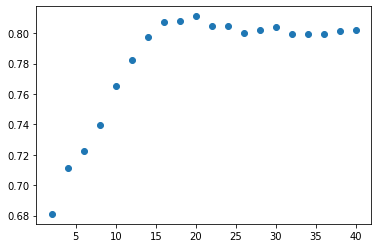

In [73]:
plt.scatter(depths, val_acc)
# len(depth)


In [74]:
importances = rf_model.named_steps['randomforestclassifier'].feature_importances_

Text(0.5, 0, 'Gini Importance')

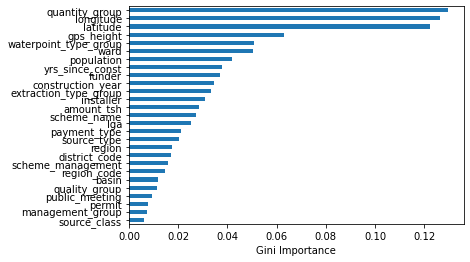

In [75]:
features = X_train.columns

feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.head(100).plot(kind= 'barh')
plt.xlabel('Gini Importance')

## Create Kaggle Submission

**Task 8:** Load `'waterpumps/test.csv'` into a DataFrame named `X_test`. Generate a list of predictions, and then put them into a DataFrame `submission`. Be sure that `submission` has the same index as `X_test` and that the column name for your predictions is `'status_group'`.  

In [76]:
# X_test = pd.read_csv(DATA_PATH + 'waterpumps/test_features.csv', index_col='id') ### This was already done
# YOUR CODE HERE
model = rf_model
X_test=X_test
submission=pd.DataFrame(model.predict(X_test), columns=['status_group'], index=X_test.index)
submission.head(25)

,status_group
id,
50785,functional
51630,functional
17168,functional
45559,non functional
49871,functional
52449,functional
24806,non functional
28965,non functional
36301,non functional


**Test 8**

**Task 9 (`stretch goal`):** Save `submission` as a csv file using [`.to_csv()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html) and submit it to our Kaggle competition.

In [77]:
# YOUR CODE HERE


In [78]:
from google.colab import drive
drive.mount('drive')

KeyboardInterrupt: ignored

In [ ]:
submission.to_csv('submission.csv')
!cp "submission.csv" "drive\My Drive"

In [ ]:
submission.to_csv()

## Explain

**Task 10 (`stretch goal`):** Make a horizontal barchart of the 10 most important features for your model.

In [ ]:
import matplotlib.pyplot as plt

# YOUR CODE HERE
raise NotImplementedError()